In [2]:
#|default_exp sgd

In [2]:
#|export
import torch

from diy_stable_diffusion.datasets import *
from diy_stable_diffusion.conv import *
from diy_stable_diffusion.learner import *
from diy_stable_diffusion.activations import *
from diy_stable_diffusion.init import *

In [3]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from diy_stable_diffusion.datasets import *
from diy_stable_diffusion.conv import *
from diy_stable_diffusion.learner import *
from diy_stable_diffusion.activations import *
from diy_stable_diffusion.init import *

In [5]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [6]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
metrics = MetricsCB(accuracy = MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_genrelu_partial = partial(GeneralRelu, leak=0.1, sub=0.4)
initweights_partial = partial(init_weights, leaky=0.1)
lrfinder_cbs = [DeviceCB(), LRFinderCB()]


# Optimizers

In [8]:
class SGD:
    def __init__(self, params, lr, wd=0.0):
        self.params = list(params)
        self.lr = lr
        self.wd=wd
        self.i = 0
        
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1
        
    def opt_step(self, p):
        p -= p.grad*self.lr
    
    def reg_step(self, p):
        if self.wd != 0:
            p *= (1 - self.lr * self.wd)
            
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

accuracy,loss,epoch,state
0.772,0.640,0,train
0.824,0.477,0,eval
0.845,0.423,1,train
0.851,0.417,1,eval
0.865,0.372,2,train
0.848,0.415,2,eval


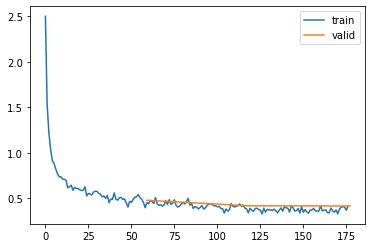

In [9]:
set_seed(42)
model = get_model(act_genrelu_partial, norm=nn.BatchNorm2d).apply(initweights_partial)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)
learn.fit(3)

## Momentum

In [10]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0.0, mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom = mom
    
    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'):
            p.grad_avg = torch.zeros_like(p.grad)
        
        p.grad_avg = p.grad_avg * self.mom + p.grad * (1-self.mom)
        p -= p.grad_avg * self.lr
        

accuracy,loss,epoch,state
0.787,0.596,0,train
0.847,0.417,0,eval
0.869,0.359,1,train
0.860,0.376,1,eval
0.886,0.312,2,train
0.869,0.360,2,eval


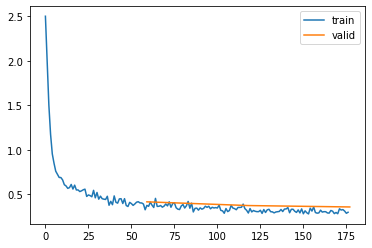

In [11]:
set_seed(42)
model=get_model(act_genrelu_partial, norm=nn.BatchNorm2d).apply(initweights_partial)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs = cbs, opt_func=Momentum)
learn.fit(3)

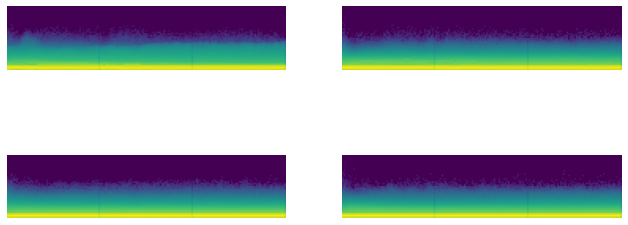

In [12]:
astats.color_dim()

# RMS Prop

In [13]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0.0, sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom, self.eps = sqr_mom, eps
    
    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'):
            p.sqr_avg = p.grad**2
        
        p.sqr_avg = self.sqr_mom * p.sqr_avg + (1-self.sqr_mom) * (p.grad ** 2)
        p -= self.lr * p.grad / (p.sqr_avg.sqrt() + self.eps)

accuracy,loss,epoch,state
0.766,0.664,0,train
0.822,0.482,0,eval
0.848,0.416,1,train
0.845,0.425,1,eval
0.866,0.367,2,train
0.851,0.403,2,eval


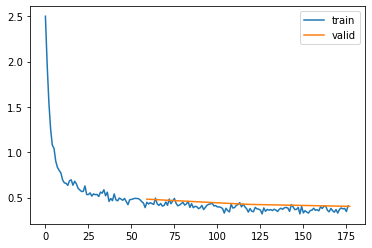

In [14]:
set_seed(42)
model = get_model(act_genrelu_partial, norm=nn.BatchNorm2d).apply(initweights_partial)
learn = TrainLearner(model, dls, loss_func=F.cross_entropy, opt_func=RMSProp, cbs=cbs, lr=3e-3)
learn.fit(3)

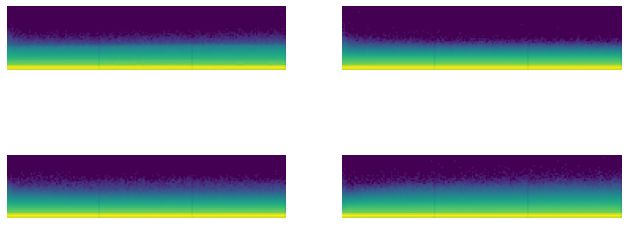

In [15]:
astats.color_dim()

## Adam

In [16]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0.0, beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps
        
    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'):
            p.grad_avg = torch.zeros_like(p.grad.data)
        
        if not hasattr(p, 'sqr_avg'):
            p.sqr_avg = torch.zeros_like(p.grad.data)
        
        p.grad_avg = self.beta1 * p.grad_avg + (1-self.beta1) * p.grad
        unbias_avg = p.grad_avg / (1 - (self.beta1 ** (self.i + 1)))
        
        p.sqr_avg = self.beta2 * p.sqr_avg + (1 - self.beta2) * p.grad ** 2
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2 ** (self.i + 1)))
        
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

accuracy,loss,epoch,state
0.791,0.583,0,train
0.839,0.429,0,eval
0.870,0.359,1,train
0.858,0.380,1,eval
0.886,0.312,2,train
0.875,0.344,2,eval


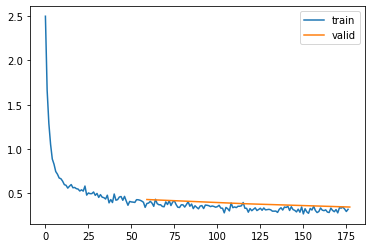

In [17]:
set_seed(42)
model=get_model(act_genrelu_partial, norm=nn.BatchNorm2d).apply(initweights_partial)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)


## Schedulers

In [32]:
' '.join(ob for ob in dir(lr_scheduler) if ob[0].isupper() and ob[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer ReduceLROnPlateau SequentialLR StepLR'

In [101]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [102]:
opt = learn.opt
dir(opt)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cuda_graph_capture_health_check',
 '_hook_for_profile',
 '_warned_capturable_if_run_uncaptured',
 '_zero_grad_profile_name',
 'add_param_group',
 'defaults',
 'load_state_dict',
 'param_groups',
 'state',
 'state_dict',
 'step',
 'zero_grad']

In [103]:
opt

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [104]:
param = next(iter(learn.model.parameters()))
st = opt.state[param]
st,opt.state.values()

({'momentum_buffer': None},
 dict_values([{'momentum_buffer': None}, {'momentum_buffer': None}, {'momentum_buffer': None}, {'momentum_buffer': None}, {'momentum_buffer': None}, {'momentum_buffer': None}, {'momentum_buffer': None}, {'momentum_buffer': None}, {'momentum_buffer': None}, {'momentum_buffer': None}]))

In [105]:
len(opt.param_groups)

1

In [106]:
pg= opt.param_groups[0]
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach']

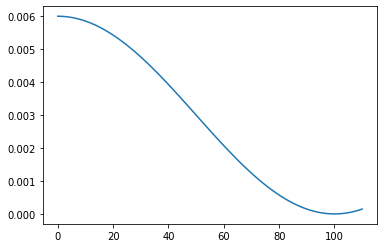

In [107]:
scheduler = lr_scheduler.CosineAnnealingLR(opt, 100)
lrs = [scheduler.get_last_lr()]
for i in range(110):
    scheduler.optimizer.step()
    scheduler.step()
    lrs.append(scheduler.get_last_lr())
plt.plot(lrs)

## Scheduler callbacks

In [119]:
#|export
class BaseSchedCB(Callback):
    def __init__(self, schedulertype):
        self.schedulertype = schedulertype
    
    def before_fit(self, learn):
        self.scheduleinstance = self.schedulertype(learn.opt)
    
    def _step(self, learn):
        if learn.training:
            self.scheduleinstance.step()

class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn):
        self._step(learn)

class HasLearnCB(Callback):
    def before_fit(self, learn):
        self.learn = learn
    def after_fit(self, learn):
        self.learn = None

class RecorderCB(Callback):
    # recorders are name=fn keyword args where values are functions to be called to capture the so-named record.
    def __init__(self, **recorders):
        self.recorders = recorders
    
    def before_fit(self, learn):
        self.records = {name:[] for name in self.recorders}
        self.param_group = learn.opt.param_groups[0]
    
    def after_batch(self, learn):
        if not learn.training:
            return
        
        # callback var here is just a general
        for name,fn in self.recorders.items():
            self.records[name].append(fn(self))
        
    def plot(self):
        for name,record in self.records.items():
            plt.plot(record, label=name)
            plt.legend()
            plt.show()
        

In [120]:
def _lr(callback):
    return callback.param_group['lr']

In [121]:
len(dls.train)

59

In [10]:
lr_scheduler.OneCycleLR

torch.optim.lr_scheduler.OneCycleLR

accuracy,loss,epoch,state
0.806,0.525,0,train
0.848,0.415,0,eval
0.878,0.330,1,train
0.879,0.330,1,eval
0.897,0.282,2,train
0.880,0.317,2,eval


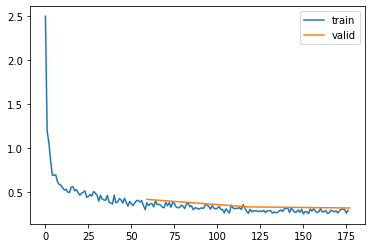

In [122]:
max_steps = 3*len(dls.train)
scheduler = partial(lr_scheduler.CosineAnnealingLR, T_max=max_steps)
set_seed(42)
model=get_model(act_genrelu_partial, norm=nn.BatchNorm2d).apply(initweights_partial)
recorder = RecorderCB(lr=_lr)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+[BatchSchedCB(scheduler), recorder], opt_func=optim.AdamW)
learn.fit(3)

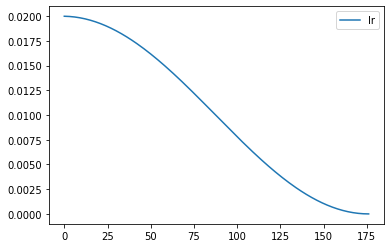

In [124]:
recorder.plot()

In [125]:
#|export
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn):
        self._step(learn)

accuracy,loss,epoch,state
0.806,0.524,0,train
0.858,0.380,0,eval
0.879,0.328,1,train
0.870,0.338,1,eval
0.898,0.275,2,train
0.884,0.309,2,eval


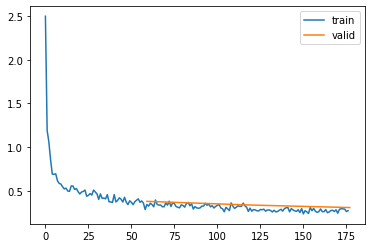

In [127]:
scheduler = partial(lr_scheduler.CosineAnnealingLR, T_max=3)
set_seed(42)
model=get_model(act_genrelu_partial, norm=nn.BatchNorm2d).apply(initweights_partial)
recorder = RecorderCB(lr=_lr)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+[EpochSchedCB(scheduler), recorder], opt_func=optim.AdamW)
learn.fit(3)

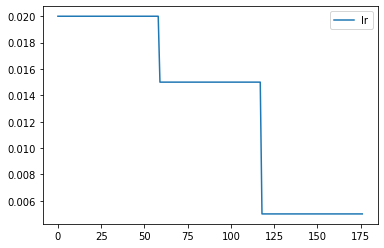

In [129]:
recorder.plot()

## 1cycle training

In [135]:
def _beta1(cb):
    return cb.param_group['betas'][0]

In [5]:
BatchSchedCB??

Object `BatchSchedCB` not found.


In [138]:
set_seed(42)
lr = 6e-2
epochs=5
max_steps = epochs * len(dls.train)
scheduler = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=max_steps)
set_seed(42)
model=get_model(act_genrelu_partial, norm=nn.BatchNorm2d).apply(initweights_partial)
recorder = RecorderCB(lr=_lr, beta1=_beta1, beta2=(lambda cb: cb.param_group['betas'][1]))
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+[BatchSchedCB(scheduler), recorder], opt_func=optim.AdamW)

accuracy,loss,epoch,state
0.767,0.659,0,train
0.841,0.458,0,eval
0.858,0.389,1,train
0.859,0.425,1,eval
0.888,0.304,2,train
0.887,0.310,2,eval
0.908,0.249,3,train
0.898,0.278,3,eval
0.923,0.210,4,train
0.903,0.265,4,eval


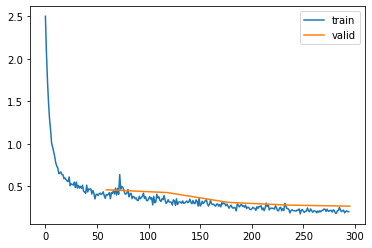

In [139]:
learn.fit(5)

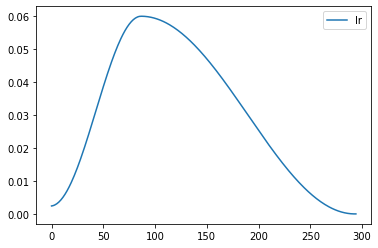

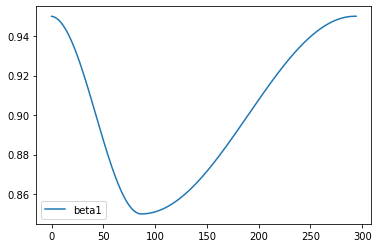

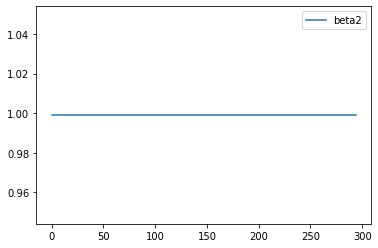

In [140]:
recorder.plot()

# Export 

In [143]:
import nbdev; nbdev.nbdev_export()